In [1]:
%load_ext autoreload
%autoreload 2
%reset -f
from custom_imports import *

In [2]:
client = Client(scheduler_file="/home/bzr0014/schedfile")

In [3]:
client.restart()

<Client: 'tcp://131.204.27.88:8786' processes=10 threads=20, memory=200.00 GB>

In [4]:
DATAROOT = "data"

In [5]:
from functools import reduce
bad_images = reduce(lambda x, y: set(x) | set(y), map(joblib.load, glob.glob(f"{DATAROOT}/bad_images.list")))

In [6]:
multi_class_images = {k: v for k, v in joblib.load(f"{DATAROOT}/multi_label_images.dict").items() 
                      if k not in bad_images}
image_names = joblib.load(f"{DATAROOT}/image_names.pkl")

In [7]:
raw_images = {k: v for k, v in dict(zip(image_names, joblib.load(f"{DATAROOT}/raw_images.pkl"))).items() 
              if k in multi_class_images}

In [8]:
original_images = {k: v for k, v in dict(zip(image_names, joblib.load(f"{DATAROOT}/images.pkl"))).items() 
                   if k in multi_class_images and k }

In [9]:
assert len(raw_images) == len(original_images)
assert len(raw_images) == len(multi_class_images)

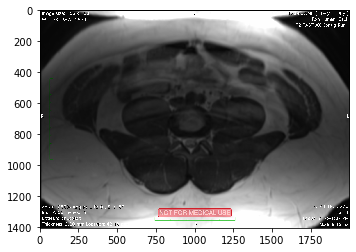

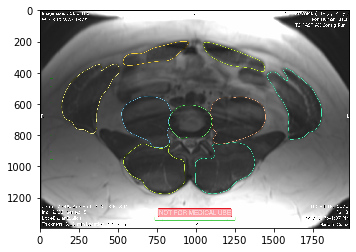

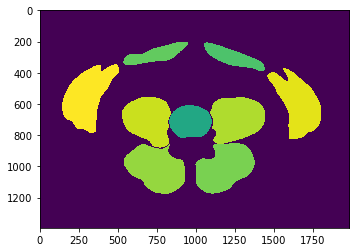

In [10]:
label = np.random.choice(list(multi_class_images.keys()))
plt.imshow(raw_images[label])
plt.show()
plt.imshow(original_images[label])
plt.show()
plt.imshow(multi_class_images[label])

In [11]:
TRAIN_SIZE = 400

In [12]:
from sklearn.model_selection import train_test_split
imgTrLabels, imgTsLabels, maskedTrLabels, maskedTsLabels = \
    train_test_split(list(original_images.keys()), list(multi_class_images.keys()), random_state=17, test_size=.6)
imgTr = {k: original_images[k] for k in imgTrLabels}
imgTs = {k: original_images[k] for k in imgTsLabels}
maskedTr = {k: multi_class_images[k] for k in maskedTrLabels}
maskedTs = {k: multi_class_images[k] for k in maskedTsLabels}
assert len(imgTr) == len(maskedTr)
assert len(imgTs) == len(maskedTs)

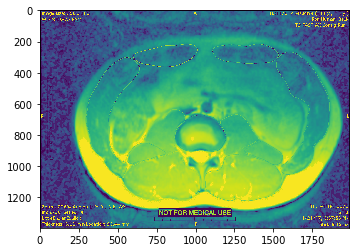

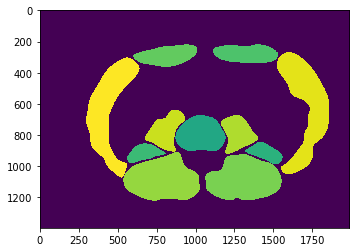

In [13]:
label = np.random.choice(list(maskedTr.keys()))
plt.imshow(cv2.equalizeHist(imgTr[label].mean(axis=2).astype('uint8')))
plt.show()
plt.imshow(maskedTr[label])

In [14]:
def clean_image(img, shape):
    if len(img.shape) > 2:
        img = img.mean(axis=2).astype('uint8')
    cleaned_hist_img = cv2.equalizeHist(img)
    gaussian_kernel_size = tuple(((x//40)//2)*2+1 for x in cleaned_hist_img.shape)
    blurred_img = cv2.GaussianBlur(cleaned_hist_img, gaussian_kernel_size, 1)
    zoom_rate = tuple(x/y for x,y in zip(shape, img.shape)) if isinstance(shape, tuple) \
                else shape if shape < 1 else shape/img.shape[0]
    out = zoom(blurred_img, zoom_rate)
    return (out-out.mean())/out.std()

def clean_mask(img, shape):
    if len(img.shape) > 2:
        img = img.sum(axis=2).astype('uint8')
    zoom_rate = tuple(x/y for x,y in zip(shape, img.shape)) if isinstance(shape, tuple) \
                else shape if shape < 1 else shape/img.shape[0]
    out = []
    for c in sorted(np.unique(img))[1:]:
        segment = (zoom((img==c)*255, zoom_rate)>0)*c
        out.append(segment)
    return np.max(np.array(out), axis=0)

#def get_image_positional_values(img):
#    w, h, *_ = img.shape
#    x, y = np.meshgrid(np.arange(w)/w, np.arange(h)/h)
#    return np.vstack([x.reshape(-1), y.reshape(-1)]).T, img.reshape(-1)



mri_analysis/3.Contiguous Set#1/Control/Control - Post/Male/Subject M5B/2-COM5B-9:50Behnam.jpg


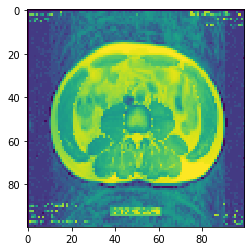

[  0 150 160 170 180 190 200 210 220 230 240 250]


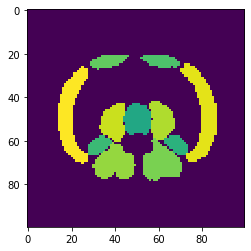

In [15]:
label = np.random.choice(list(maskedTr.keys()))
#label = "mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Female/Subject WF5B/1-WF5B-4:50RepBeh.jpg"
#label = 'mri_analysis/4.Contiguous Set#2/Control/Control - Pre/Female/Subject F4/3-COF4-15:50Rep-Beh.jpg'
print(label)
plt.imshow(clean_image(imgTr[label], (100, 100)))
plt.show()
tmp = clean_mask(maskedTr[label], (100, 100))
plt.imshow(tmp)
print(np.unique(tmp))

In [16]:
imgTrB = bag.from_sequence(imgTr.values())
maskedTrB = bag.from_sequence(maskedTr.values())

In [17]:
cleaned_images_bag = imgTrB.map(clean_image, shape=300).persist()#[delayed(clean_image)(x, 200) for x in imgTr.values()]
cleaned_masks_bag = maskedTrB.map(clean_mask, shape=300).persist()#[delayed(clean_image)(x, 200) for x in imgTr.values()]

In [18]:
n = np.random.randint(len(cleaned_images_bag))
plt.imshow(cleaned_images_bag[n])
plt.show()
plt.imshow(cleaned_masks_bag[n])

TypeError: object of type 'Bag' has no len()

In [19]:
def sample(x, y, neighSize, step, rnd=None):
    m1 = neighSize//2
    m2 = neighSize-m1
    w, h, *_ = x.shape
    x_out = []
    y_out = []
    if rnd is None:
        rndmask = np.zeros(x.shape)
    else:
        rndmask = np.random.rand(*x.shape)
    for i in range(m1, w-m2, step):
        for j in range(m1, h-m2, step):
            if y[i, j] == 0 and rndmask[i, j] > rnd:
                continue
            x_out.append(x[i-m1:i+m2, j-m1:j+m2])
            y_out.append(y[i, j])
    x = np.array(x_out)
    y = np.array(y_out)
    return x.reshape(*x.shape, 1), y.reshape(*y.shape, 1)

In [20]:
XY_bag = bag.map(sample, cleaned_images_bag, cleaned_masks_bag, 41, 1, rnd=.1)

In [21]:
XY = XY_bag.compute()

In [22]:
X = np.concatenate([x[0] for x in XY])

In [23]:
Y = np.concatenate([x[1] for x in XY])
encoder = OneHotEncoder()
#Y = encoder.fit_transform(Y).toarray()
Y[Y>0] = Y[Y>0]/10 -14

In [109]:
input_ = tf.keras.layers.Input(shape=(41, 41, 1))
hidden1 = tf.keras.layers.Conv2D(16, (15, 15), use_bias=False)(input_)
bn1 = tf.keras.layers.BatchNormalization()(hidden1)
r1 = tf.keras.layers.ELU()(bn1)
hidden2 = tf.keras.layers.Conv2D(1, (15, 15), use_bias=False)(r1)
bn2 = tf.keras.layers.BatchNormalization()(hidden2)
r2 = tf.keras.layers.ELU()(bn2)
small_input = tf.keras.layers.MaxPool2D([3, 3], 3)(input_)
flat_input = tf.keras.layers.Flatten()(small_input)
flat_r2 = tf.keras.layers.Flatten()(r2)
concat = tf.keras.layers.concatenate([flat_input, flat_r2])
d1 = tf.keras.layers.Dense(100, activation='elu', use_bias=False)(concat)
bnd1 = tf.keras.layers.BatchNormalization()(d1)
d2 = tf.keras.layers.Dense(50, activation='elu', use_bias=False)(bnd1)
bnd2 = tf.keras.layers.BatchNormalization()(d2)
out = tf.keras.layers.Dense(12, use_bias=False, activation='sigmoid')(bnd2)
model = tf.keras.Model(inputs = [input_], outputs=[out])

In [110]:
concat

<tf.Tensor 'concatenate_29/concat:0' shape=(?, 338) dtype=float32>

In [111]:
optimizer = tf.keras.optimizers.Nadam()
loss = tf.keras.losses.sparse_categorical_crossentropy
model.compile(optimizer, loss, metrics=['acc'])

In [113]:
Xtr, Xts, Ytr, Yts = train_test_split(X, Y, test_size=.2, random_state=18)

In [114]:
model.fit(Xtr, Ytr, batch_size=64, 
          shuffle=True, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)], 
          epochs=1000, validation_split=.2)

Train on 3391180 samples, validate on 847795 samples
Epoch 1/1000
 274688/3391180 [=>............................] - ETA: 1:51:40 - loss: 1.2753 - acc: 0.5586

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 547136/3391180 [===>..........................] - ETA: 1:41:47 - loss: 1.1207 - acc: 0.6128

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 818304/3391180 [======>.......................] - ETA: 1:31:25 - loss: 1.0368 - acc: 0.6422

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1096832/3391180 [========>.....................] - ETA: 1:21:23 - loss: 0.9783 - acc: 0.6624

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1353472/3391180 [==========>...................] - ETA: 1:12:12 - loss: 0.9380 - acc: 0.6762

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1633728/3391180 [=============>................] - ETA: 1:02:14 - loss: 0.9043 - acc: 0.6878

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1916864/3391180 [===============>..............] - ETA: 52:09 - loss: 0.8761 - acc: 0.6973

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2194496/3391180 [==================>...........] - ETA: 42:18 - loss: 0.8534 - acc: 0.7049

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2451904/3391180 [====================>.........] - ETA: 33:09 - loss: 0.8354 - acc: 0.7110

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2734144/3391180 [=======================>......] - ETA: 23:11 - loss: 0.8183 - acc: 0.7168

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3014336/3391180 [=========================>....] - ETA: 13:17 - loss: 0.8032 - acc: 0.7220

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3295680/3391180 [============================>.] - ETA: 3:21 - loss: 0.7901 - acc: 0.7264

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3391180/3391180 [==============================] - 7410s 2ms/sample - loss: 0.7859 - acc: 0.7279 - val_loss: 0.5759 - val_acc: 0.7997
Epoch 2/1000
 184384/3391180 [>.............................] - ETA: 1:50:10 - loss: 0.6347 - acc: 0.7790

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 438976/3391180 [==>...........................] - ETA: 1:41:47 - loss: 0.6310 - acc: 0.7807

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 714432/3391180 [=====>........................] - ETA: 1:32:12 - loss: 0.6272 - acc: 0.7819

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 989056/3391180 [=======>......................] - ETA: 1:22:47 - loss: 0.6231 - acc: 0.7832

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1266240/3391180 [==========>...................] - ETA: 1:13:13 - loss: 0.6191 - acc: 0.7846

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1545344/3391180 [============>.................] - ETA: 1:03:33 - loss: 0.6159 - acc: 0.7857

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1827712/3391180 [===============>..............] - ETA: 53:51 - loss: 0.6129 - acc: 0.7867

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2108160/3391180 [=================>............] - ETA: 44:10 - loss: 0.6098 - acc: 0.7878

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2358400/3391180 [===================>..........] - ETA: 35:33 - loss: 0.6074 - acc: 0.7887

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2637696/3391180 [======================>.......] - ETA: 25:56 - loss: 0.6049 - acc: 0.7896

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2908672/3391180 [========================>.....] - ETA: 16:37 - loss: 0.6023 - acc: 0.7904

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3180672/3391180 [===========================>..] - ETA: 7:15 - loss: 0.5998 - acc: 0.7913

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3391180/3391180 [==============================] - 7250s 2ms/sample - loss: 0.5980 - acc: 0.7919 - val_loss: 0.4890 - val_acc: 0.8297
Epoch 3/1000
  59968/3391180 [..............................] - ETA: 1:54:35 - loss: 0.5676 - acc: 0.8029

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 329024/3391180 [=>............................] - ETA: 1:45:17 - loss: 0.5657 - acc: 0.8024

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 606848/3391180 [====>.........................] - ETA: 1:35:53 - loss: 0.5625 - acc: 0.8035

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 887104/3391180 [======>.......................] - ETA: 1:26:12 - loss: 0.5618 - acc: 0.8037

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1131904/3391180 [=========>....................] - ETA: 1:17:43 - loss: 0.5612 - acc: 0.8040

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1407552/3391180 [===========>..................] - ETA: 1:08:13 - loss: 0.5599 - acc: 0.8045

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1676608/3391180 [=============>................] - ETA: 59:00 - loss: 0.5586 - acc: 0.8051

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1946368/3391180 [================>.............] - ETA: 49:44 - loss: 0.5576 - acc: 0.8054

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2225408/3391180 [==================>...........] - ETA: 40:07 - loss: 0.5561 - acc: 0.8061

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2502912/3391180 [=====================>........] - ETA: 30:35 - loss: 0.5553 - acc: 0.8063

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2772928/3391180 [=======================>......] - ETA: 21:17 - loss: 0.5543 - acc: 0.8066

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3049152/3391180 [=========================>....] - ETA: 11:46 - loss: 0.5533 - acc: 0.8070

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3323584/3391180 [============================>.] - ETA: 2:19 - loss: 0.5521 - acc: 0.8074

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 206784/3391180 [>.............................] - ETA: 1:52:54 - loss: 0.5327 - acc: 0.8134

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 486400/3391180 [===>..........................] - ETA: 1:42:34 - loss: 0.5324 - acc: 0.8140

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 728320/3391180 [=====>........................] - ETA: 1:33:44 - loss: 0.5323 - acc: 0.8141

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1008000/3391180 [=======>......................] - ETA: 1:23:49 - loss: 0.5316 - acc: 0.8143

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1290048/3391180 [==========>...................] - ETA: 1:13:46 - loss: 0.5308 - acc: 0.8144

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1566912/3391180 [============>.................] - ETA: 1:04:07 - loss: 0.5302 - acc: 0.8147

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1841856/3391180 [===============>..............] - ETA: 54:24 - loss: 0.5295 - acc: 0.8149

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2120576/3391180 [=================>............] - ETA: 44:40 - loss: 0.5286 - acc: 0.8153

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2398656/3391180 [====================>.........] - ETA: 34:54 - loss: 0.5281 - acc: 0.8156

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2667072/3391180 [======================>.......] - ETA: 25:27 - loss: 0.5274 - acc: 0.8159

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2947264/3391180 [=========================>....] - ETA: 15:37 - loss: 0.5267 - acc: 0.8162

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3225536/3391180 [===========================>..] - ETA: 5:49 - loss: 0.5261 - acc: 0.8164

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3391180/3391180 [==============================] - 7401s 2ms/sample - loss: 0.5259 - acc: 0.8164 - val_loss: 0.4307 - val_acc: 0.8505
Epoch 5/1000
 110464/3391180 [..............................] - ETA: 1:55:00 - loss: 0.5063 - acc: 0.8231

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 388416/3391180 [==>...........................] - ETA: 1:45:07 - loss: 0.5102 - acc: 0.8218

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1413568/3391180 [===========>..................] - ETA: 1:09:09 - loss: 0.5122 - acc: 0.8214

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1682560/3391180 [=============>................] - ETA: 59:44 - loss: 0.5114 - acc: 0.8216

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1959040/3391180 [================>.............] - ETA: 50:01 - loss: 0.5108 - acc: 0.8218

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2233856/3391180 [==================>...........] - ETA: 40:24 - loss: 0.5107 - acc: 0.8217

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2506944/3391180 [=====================>........] - ETA: 30:52 - loss: 0.5100 - acc: 0.8220

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3391180/3391180 [==============================] - 7360s 2ms/sample - loss: 0.5085 - acc: 0.8224 - val_loss: 0.4372 - val_acc: 0.8479
Epoch 6/1000
 781440/3391180 [=====>........................] - ETA: 1:31:22 - loss: 0.4985 - acc: 0.8262

KeyboardInterrupt: 

In [116]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 41, 41, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 27, 27, 16)   3600        input_39[0][0]                   
__________________________________________________________________________________________________
batch_normalization_100 (BatchN (None, 27, 27, 16)   64          conv2d_56[0][0]                  
__________________________________________________________________________________________________
elu_52 (ELU)                    (None, 27, 27, 16)   0           batch_normalization_100[0][0]    
___________________________________________________________________________________________

In [144]:
#model.save("data/model_04_muti_class_cnn_v04_41x41.model")

In [1]:
%reset -f
from custom_imports import *
client = Client(scheduler_file="/home/bzr0014/schedfile")
DATAROOT = "data"
image_names = joblib.load(f"{DATAROOT}/image_names.pkl")
raw_images = dict(zip(image_names, joblib.load(f"{DATAROOT}/raw_images.pkl")))
#label =

In [97]:
#classes = dict(zip(image_names, joblib.load(f"{DATAROOT}/raw_images.pkl")))
classes = joblib.load("data/multi_label_images.dict")

In [98]:
len(classes)

776

In [115]:
def clean_image(img, shape):
    if len(img.shape) > 2:
        img = img.mean(axis=2).astype('uint8')
    cleaned_hist_img = cv2.equalizeHist(img)
    gaussian_kernel_size = tuple(((x//40)//2)*2+1 for x in cleaned_hist_img.shape)
    blurred_img = cv2.GaussianBlur(cleaned_hist_img, gaussian_kernel_size, 1)
    zoom_rate = tuple(x/y for x,y in zip(shape, img.shape)) if isinstance(shape, tuple) \
                else shape if shape < 1 else shape/img.shape[0]
    out = zoom(blurred_img, zoom_rate)
    return (out-out.mean())/out.std()
def clean_mask(img, shape):
    if len(img.shape) > 2:
        img = img.sum(axis=2).astype('uint8')
    s = shape[::-1] if isinstance(shape, tuple) else (int(h/w*shape), shape)
    out = []
    for c in sorted(np.unique(img))[1:]:
        segment = (cv2.resize((img==c).astype('uint8'), s)>0)*c
        out.append(segment)
    try:
        return np.max(np.array(out), axis=0)
    except:
        return None

In [3]:
X_d = {k: delayed(clean_image)(v, shape=300) for k, v in raw_images.items()}

In [ ]:
Y_d = {k: delayed(clean_mask)(v, shape=300) for k, v in raw_images.items()}

In [4]:
X = compute(X_d)[0]

In [5]:
from tensorflow.keras.models import load_model

In [6]:
model = load_model("models/model_04_muti_class_cnn_v04_41x41.model")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
def sample(x, neighSize, step):
    m1 = neighSize//2
    m2 = neighSize-m1
    w, h, *_ = x.shape
    x_out = []
    for i in range(m1, w-m2, step):
        for j in range(m1, h-m2, step):
            x_out.append(x[i-m1:i+m2, j-m1:j+m2])
    x = np.array(x_out)
    return x.reshape(*x.shape, 1)

In [9]:
labels = [x for x in X]

In [15]:
client.restart()

<Client: 'tcp://131.204.27.88:8786' processes=11 threads=22, memory=220.00 GB>

In [16]:
Xs = client.scatter(list(X.values()))

In [18]:
result = {}
f = client.submit(sample, Xs[0], 41, 1)
for i in range(len(labels)-1):
    print(labels[i])
    f2 = client.submit(sample, Xs[i+1], 41, 1)
    w, h = X[labels[i]].shape
    print("started")
    pred = np.argmax(model.predict(f.result()), axis=1)
    print("finished")
    result[labels[i]] = pred.reshape(w-41, h-41)
    del f
    f = f2

mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/4-COF7-22:50Behnam.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/2-COF7-12:50Behnam.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/1-COF7-6:50Behnam.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/3-COF7-17:50Behnam.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F5/1-COF5-5:50Behnam.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F5/4-COF5-21:50Behnam.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F5/2-COF5-11:50Behnam.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F5/3-COF5-16:50Behnam.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F2/1-COF2-6:50Behnam.jpg
started
fini

finished
mri_analysis/3.Contiguous Set#1/Control/Control - Post/Female/Subject F3B/4-COF3B-21:50BehnamPost.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Control/Control - Post/Female/Subject F3B/1-COF3B-4:50BehnamPost.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Control/Control - Post/Female/Subject F3B/3-COF3B-15:50BehnamPost.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Control/Control - Post/Female/Subject F2B/4-COF2B-21:50BehnamPost.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Control/Control - Post/Female/Subject F2B/3-COF2B-16:50BehnamPost.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Control/Control - Post/Female/Subject F2B/2-COF2B-10:50BehnamPost.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Control/Control - Post/Female/Subject F2B/1-COF2B-5:50BehnamPost.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Control/Control - Post/Male/Subject M2B/2-COM2B-11:50Behnam.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Control/Control

finished
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Post/Male/Subject WM9B/3-WM9B-16:50-BehnamPost.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Post/Male/Subject WM9B/4-WM9B-22:50-BehnamPost.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Post/Male/Subject WM9B/2-WM9B-10:50-BehnamPost.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Post/Male/Subject WM9B/1-WM9B-6:50-BehnamPost.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Post/Male/Subject WM3B/4-WM3B-22:50-BehnamPost.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Post/Male/Subject WM3B/2-WM3B-9:50-BehnamPost.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Post/Male/Subject WM3B/3-WM3B-15:50-BehnamPost.jpg
started
finished
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Post/

finished
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Female/Subject F7/1.COF7-2:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Female/Subject F7/3.COF7-10:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Female/Subject F7/4.COF7-15:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Female/Subject F7/2.COF7-7:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Female/Subject F5/2.COF5-7:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Female/Subject F5/3.COF5-10:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Female/Subject F5/4.COF5-14:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Female/Subject F5/1.COF5-3:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DON

finished
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Post/Female/Subject F5B/1.COF5B-3:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Post/Female/Subject F5B/3.COF5B-11:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Post/Female/Subject F3B/4.COF3B-14:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Post/Female/Subject F3B/2.COF3B-7:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Post/Female/Subject F3B/3.COF3B-10:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Post/Female/Subject F3B/1.COF3B-2:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Post/Female/Subject F2B/2.COF2B-7:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Post/Female/Subject F2B/4.COF2B-15:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Post/Female/Subject F2B/1.CO

finished
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Male/Weight Lifting - Post/Subject W2B/4.WM02B-14:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Male/Weight Lifting - Post/Subject W1B/3.WM1B-10:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Male/Weight Lifting - Post/Subject W1B/1.WM1B-3:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Male/Weight Lifting - Post/Subject W1B/2.WM1B-7:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Male/Weight Lifting - Post/Subject W1B/4.WM1B-14:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Male/Weight Lifting - Post/Subject W9B/3.WM9B-11:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Male/Weight Lifting - Post/Subject W

finished
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W9/4.FCWM9-14:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W9/1.FCWM9-3:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W9/2.FCWM9-6:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W3/1.FCWM3-3:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W3/3.FCWM3-11:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W3/2.FCWM3-6:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W3/4.FCWM3-14:16.jpg
started
finished
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W4/3.FCWM4-11:16.jpg
started
finished
mri

finished
mri_analysis/2.Multigroup Set#2/Control/Control - Post/Female/Subject F7B/1-COF7B-3:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Control/Control - Post/Female/Subject F7B/2-COF7B-7:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Control/Control - Post/Female/Subject F4B/2-COF4B-7:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Control/Control - Post/Female/Subject F4B/1-COF4B-3:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Control/Control - Post/Female/Subject F4B/4-COF4B-14:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Control/Control - Post/Female/Subject F4B/3-COF4B-10:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Control/Control - Post/Female/Subject F5B/4-COF5B-15:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Control/Control - Post/Female/Subject F5B/1-COF5B-3:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Control/Control - Post/Female/Subject F5B/2-

finished
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM6B/4-WM6B-14:16RepPre.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM4B/4-WM4B-14:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM4B/3-WM4B-10:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM4B/2-WM4B-7:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM4B/1-WM4B-3:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM2B/4-WM2B-14:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM2B/3-WM2B-11:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM2B/1-WM2B-3:16RepBeh

finished
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM8/1-WM8-3:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM8/3-WM8-10:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM8/4-WM8-14:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM3/3-WM3-11:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM3/2-WM3-6:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM3/4-WM3-14:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM3/1-WM3-3:16RepBeh.jpg
started
finished
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM2/4-WM2-14:16RepBeh.jpg
started
finished
mr

finished
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F7B/1-COF7B-5:50RepBeh.jpg
started
finished
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F7B/3-COF7B-16:50RepBeh.jpg
started
finished
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F4B/2-COF4B-9:50RepBeh.jpg
started
finished
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F4B/4-COF4B-20:50RepBeh.jpg
started
finished
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F4B/1-COF4B-4:50RepBeh.jpg
started
finished
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F4B/3-COF4B-15:50RepBeh.jpg
started
finished
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F5B/1-COF5B-6:50RepBeh.jpg
started
finished
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F5B/4-COF5B-22:50RepBeh.jpg
started
finished
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Female/Subject F5B/3

finished
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM6B/2-WM6B-8:50RepBeh.jpg
started
finished
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM4B/3-WM4B-16:50RepBeh.jpg
started
finished
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM4B/4-WM4B-22:50RepBeh.jpg
started
finished
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM4B/1-WM4B-3:50RepBeh.jpg
started
finished
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM4B/2-WM4B-10:50RepBeh.jpg
started
finished
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM2B/3-WM2B-15:50RepBeh.jpg
started
finished
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM2B/2-WM2B-10:50RepBeh.jpg
started
finished
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM2B/4-WM2B-21:50RepBe

finished
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM2/2-FCWM2-9:50Beh-Rep.jpg
started
finished
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM2/3-FCWM2-14:50Beh-Rep.jpg
started
finished
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM2/4-FCWM2-20:50Beh-Rep.jpg
started
finished


In [20]:
tmp = list(result.values())

In [48]:
mkdir data/predicted_04_multi_class_cnn_v03

mkdir: cannot create directory ‘data/predicted_04_multi_class_cnn_v03’: File exists


In [50]:
for k, v in result.items():
    print(k)
    joblib.dump(v, f"data/predicted_04_multi_class_cnn_v03/{k.split('/')[-1]}")

mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/4-COF7-22:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/2-COF7-12:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/1-COF7-6:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/3-COF7-17:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F5/1-COF5-5:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F5/4-COF5-21:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F5/2-COF5-11:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F5/3-COF5-16:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F2/1-COF2-6:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F2/3-COF2-17:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre

mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Post/Male/Subject WM3B/1-WM3B-3:50-BehnamPost.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Post/Male/Subject WM1B/2-WM1B-9:50-BehnamPost.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Post/Male/Subject WM1B/1-WM1B-3:50-BehnamPost.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Post/Male/Subject WM1B/3-WM1B-15:50-BehnamPost.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Post/Male/Subject WM1B/4-WM1B-21:50-BehnamPost.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Post/Male/Subject WM8B/2-WM8B-9:50-BehnamPost.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Post/Male/Subject WM8B/3-WM8B-16:50-BehnamPost.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Post/Male/Subject WM8B/4-WM8B-22:50-BehnamPost.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Post/Male/Subject WM

mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Male/Weight Lifting - Post/Subject W6B/2.WM6B-7:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Male/Weight Lifting - Post/Subject W6B/4.WM6B-14:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Male/Weight Lifting - Post/Subject W4B/1.WM4B-3:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Male/Weight Lifting - Post/Subject W4B/3.WM4B-10:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Male/Weight Lifting - Post/Subject W4B/4.WM4B-14:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Male/Weight Lifting - Post/Subject W4B/2.WM4B-7:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Male/Weight Lifting - Post/Subject W3B/1.WM3B-3:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Male/Weight Lifting 

mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM1B/2-WM1B-7:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM8B/4-WM8B-14:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM8B/1-WM8B-3:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM8B/2-WM8B-6:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM8B/3-WM8B-10:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Female/Subject WF5/1-WF5-2:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Female/Subject WF5/3-WF5-11:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Female/Subject WF5/2-WF5-7:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Female/Subject WF5/4-WF5-15:16RepBeh.jpg
mri_analysis/2.Mult

mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM4B/1-WM4B-3:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM4B/2-WM4B-10:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM2B/3-WM2B-15:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM2B/2-WM2B-10:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM2B/4-WM2B-21:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM2B/1-WM2B-4:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM9B/4-WM9B-22:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM9B/2-WM9B-10:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Post/Male/Subject WM9B/1-WM9B-6:50RepBeh.jpg
mri_analysis/

In [172]:
files = glob.glob("data/predicted_04_multi_class_cnn_v03/*jpg")

In [177]:
result = {file.split("/")[-1]: joblib.load(file) for file in files}

In [78]:
tmp = list(result.values())
x_temp = list(X.values())

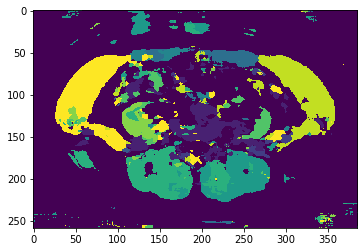

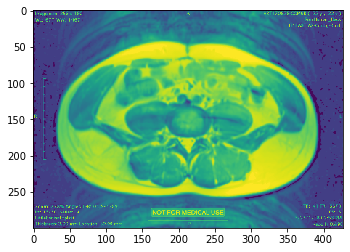

In [95]:
n = np.random.randint(len(tmp))
plt.imshow(tmp[n])
plt.show()
plt.imshow(x_temp[n])

In [62]:
len(X)

832

In [150]:
classes_cleaned = compute({k: delayed(clean_mask)(v, shape=300) for k, v in classes.items()})[0]

In [194]:
count = 0
centers = {}
for k, v in classes_cleaned.items():
    if v is None:
        continue
    print(k)
    v = v.copy()
    v[v>1] = v[v>1]/10-14
    f = result[k.split("/")[-1]].copy()

    w, h = f.shape
    t = v[20:20+w, 20:20+h]
    cond = np.where((t==0) & (np.random.rand(*t.shape)>.2))
    f[cond] = 0
    cond = np.where((t>1) & (np.random.rand(*t.shape)>.9))
    f[cond] = t[cond]
    cond = np.where((t==1) & (np.random.rand(*t.shape)>.3))
    f[cond] = t[cond]
    #fig, axes = plt.subplots(1, 4, figsize=(10, 5))
    #axes[0].imshow(f)
    #axes[1].imshow(v)
    #axes[2].imshow(f)
    #axes[3].imshow(raw_images[k])
    #plt.show()
    count += 1
    d = {}
    for i in range(1, 12):
        d[(i+14)*10] = np.array(np.where(f==i)).mean(axis=1)
    centers[k] = d
    #if count > 20: break

mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/4-COF7-22:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/2-COF7-12:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/1-COF7-6:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F7/3-COF7-17:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F5/1-COF5-5:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F5/4-COF5-21:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F5/2-COF5-11:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F5/3-COF5-16:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F2/1-COF2-6:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre/Female/Subject F2/3-COF2-17:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Pre

mri_analysis/3.Contiguous Set#1/Control/Control - Post/Male/Subject M3B/1-COM3B-2:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Post/Male/Subject M3B/2-COM3B-9:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Post/Male/Subject M4B/3-COM4B-16:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Post/Male/Subject M4B/2-COM4B-10:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Post/Male/Subject M4B/1-COM4B-5:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Post/Male/Subject M4B/4-COM4B-22:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Post/Male/Subject M5B/2-COM5B-9:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Post/Male/Subject M5B/1-COM5B-3:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Post/Male/Subject M5B/4-COM5B-20:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Control/Control - Post/Male/Subject M5B/3-COM5B-15:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Liftin

mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Female/Subject WF1/1-FCWF1-5:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Female/Subject WF1/4-FCWF1-21:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Female/Subject WF1/2-FCWF1-10:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM4/1-FCWM4-2:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM4/2-FCWM4-8:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM4/3-FCWM4-15:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM9/1-FCWM9-1:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM9/2-FCWM9-4:50Behnam.jpg
mri_analysis/3.Contiguous Set#1/Weight Lifting/Weight Lifting - Pre/Male/Subject WM9/4-FCWM9-17:50Behnam.jpg
mri_analysis/3.Con

/home/bzr0014/anaconda3/envs/tensorGpu4/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice.


mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Female/Subject F6/1.COF6-3:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Female/Subject F6/4.COF6-15:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Female/Subject F6/2.COF6-6:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Male/Subject M3/1.CO3-3:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Male/Subject M3/4.CO3-15:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Male/Subject M3/2.CO3-8:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Male/Subject M3/3.CO3-11:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Male/Subject M5/3.CO5-11:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Male/Subject M5/1.CO5-3:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Control/Control - Pre/Controls-Male/Subject M5/2.CO5-7:16.j

mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF4B/4.WF4B-21:50.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF4B/3.WF4B-15:50.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF4B/1.WF4B-3:50.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF5B/1.WF5B-3:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF5B/2.WF5B-7:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF5B/4.WF5B-15:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF5B/3.WF5B-11:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Post/Female/Post-training/Subject WF1B/4.WF1B-14:16.jpg
mri

mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W8/1.FCWM8-4:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W8/3.FCWM8-10:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W8/2.FCWM8-7:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W9/3.FCWM9-11:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W9/4.FCWM9-14:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W9/1.FCWM9-3:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W9/2.FCWM9-6:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W3/1.FCWM3-3:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weight Lifting/Weight Lifting - Pre/Male/Subject W3/3.FCWM3-11:16.jpg
mri_analysis/1.Multigroup Set#1_DONE/Weigh

mri_analysis/2.Multigroup Set#2/Control/Control - Post/Male/Subject M1B/1-COM1B-2:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Control/Control - Post/Male/Subject M1B/2-COM1B-7:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Control/Control - Post/Male/Subject M1B/3-COM1B-11:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Control/Control - Post/Male/Subject M6B/1-COM6B-3:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Control/Control - Post/Male/Subject M6B/3-COM6B-11:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Control/Control - Post/Male/Subject M6B/4-COM6B-15:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Control/Control - Post/Male/Subject M6B/2-COM6B-6:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Control/Control - Post/Male/Subject M3B/2-COM3B-6:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Control/Control - Post/Male/Subject M3B/4-COM3B-14:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Control/Control - Post/Male/Subject M3B/3-COM3B-10:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Control/Contr

mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM1/2-WM1-7:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM1/1-WM1-3:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM1/4-WM1-14:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM1/3-WM1-10:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM8/1-WM8-3:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM8/3-WM8-10:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM8/4-WM8-14:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM3/3-WM3-11:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM3/2-WM3-6:16RepBeh.jpg
mri_analysis/2.Multigroup Set#2/Weight Li

mri_analysis/4.Contiguous Set#2/Control/Control - Post/Male/Subject M2B/4-COM2B-22:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Male/Subject M2B/3-COM2B-17:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Male/Subject M1B/1-COM1B-2:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Male/Subject M1B/3-COM1B-14:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Male/Subject M1B/4-COM1B-21:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Male/Subject M1B/2-COM1B-9:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Male/Subject M6B/4-COM6B-20:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Male/Subject M6B/2-COM6B-9:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Male/Subject M6B/1-COM6B-4:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Control - Post/Male/Subject M6B/3-COM6B-15:50RepBeh.jpg
mri_analysis/4.Contiguous Set#2/Control/Cont

mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Female/Subject WF1/4-FCWF1-21:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Female/Subject WF1/2-FCWF1-10:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Female/Subject WF1/1-FCWF1-5:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Female/Subject WF1/3-FCWF1-16:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM4/2-FCWM4-9:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM4/1-FCWM4-2:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM4/3-FCWM4-15:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM9/2-FCWM9-4:50Beh-Rep.jpg
mri_analysis/4.Contiguous Set#2/Weight Lifting/Weight Lifting - Pre/Male/Subject WM9/3-FCWM9-10:50Beh-Rep.jpg
mri_an

KeyError: '1-FCWM2-3:50Beh-Rep.jpg'